### Environments

In [1]:
from preprocess import * 
from model import *
from train import *
from evaluate import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Preprocess

In [3]:
text_field, form_field = generate_field()

In [4]:
train_dataset = generate_dataset('seq2seq_geoqueries/train.csv', 'csv', [("Text", text_field), ("Form", form_field)], False)
test_dataset = generate_dataset('seq2seq_geoqueries/test.csv', 'csv', [("Text", text_field), ("Form", form_field)], False)

In [5]:
text_field.build_vocab(train_dataset, min_freq=2)
form_field.build_vocab(train_dataset, min_freq=1)

In [6]:
batch_size = 10
train_iterator = generate_iterator(train_dataset, batch_size, True)
train_iterator_beam = generate_iterator(train_dataset, 1, True)
test_iterator_beam = generate_iterator(test_dataset, 1, False, lambda x: len(x.Text[0]))

### Model

In [7]:
emb_dim = 200
hid_dim = emb_dim
encoder = Encoder_Attention(emb_dim, hid_dim, len(text_field.vocab.stoi), device, 1, False, 0)
decoder = Decoder_Attention(emb_dim, hid_dim, len(form_field.vocab.stoi), device, 1, False, 0, 0)
seq2seq = Seq2Seq_Attention(encoder, decoder, device, form_field, 0.5)
# encoder = Encoder(emb_dim, hid_dim, len(text_field.vocab.stoi), device, 1, False, 0)
# decoder = Decoder(emb_dim, hid_dim, len(form_field.vocab.stoi), device, 1, False, 0, 0)
# seq2seq = Seq2Seq(encoder, decoder, device, form_field, 0.5)
seq2seq.apply(init_weights)
seq2seq.to(device)

Seq2Seq_Attention(
  (encoder): Encoder_Attention(
    (embed): Embedding(104, 200)
    (lstm): LSTM(200, 200)
  )
  (decoder): Decoder_Attention(
    (embed): Embedding(55, 200)
    (lstm): LSTM(200, 200)
    (W1): Linear(in_features=200, out_features=200, bias=False)
    (W2): Linear(in_features=200, out_features=200, bias=False)
    (Tanh): Tanh()
    (dropout): Dropout(p=0, inplace=False)
    (linear): Linear(in_features=200, out_features=55, bias=True)
    (softmax): Softmax(dim=1)
  )
)

In [8]:
for name, param in seq2seq.named_parameters():
    print(name)
    print(param.shape)

encoder.embed.weight
torch.Size([104, 200])
encoder.lstm.weight_ih_l0
torch.Size([800, 200])
encoder.lstm.weight_hh_l0
torch.Size([800, 200])
encoder.lstm.bias_ih_l0
torch.Size([800])
encoder.lstm.bias_hh_l0
torch.Size([800])
decoder.embed.weight
torch.Size([55, 200])
decoder.lstm.weight_ih_l0
torch.Size([800, 200])
decoder.lstm.weight_hh_l0
torch.Size([800, 200])
decoder.lstm.bias_ih_l0
torch.Size([800])
decoder.lstm.bias_hh_l0
torch.Size([800])
decoder.W1.weight
torch.Size([200, 200])
decoder.W2.weight
torch.Size([200, 200])
decoder.linear.weight
torch.Size([55, 200])
decoder.linear.bias
torch.Size([55])


In [9]:
criterion, optimzier = generate_criterion_and_optimzier(form_field.vocab.stoi['<pad>'], seq2seq.parameters(), 1e-4, 0.95)

### Train

In [10]:
epoch_num = 20
loss_hist = train(epoch_num, seq2seq, train_iterator, optimzier, criterion, device)

0 151.7109785715739
1 141.98718643188477
2 141.867911529541
3 139.90801773071288
4 141.87744115193684
5 143.3367446899414
6 143.30537923177084
7 142.1083443959554
8 144.01649119059246
9 140.5658494313558
10 141.054109954834
11 140.60072758992513
12 141.45082728068033
13 144.05261357625326
14 143.28881378173827
15 141.83767534891766
16 144.05521354675292
17 139.98696670532226
18 141.74358940124512
19 140.34753227233887


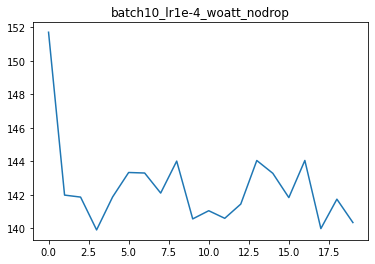

In [11]:
plot_loss(loss_hist, "batch10_lr1e-4_woatt_nodrop")

In [12]:
save_model(seq2seq, "models/epoch20_batch10_lr1e-4_woatt_nodrop_ss0.5.pth")

### Test

In [13]:
evaluate(seq2seq, train_iterator_beam, device, form_field, len(train_dataset))

10 / 600
20 / 600
30 / 600
40 / 600
50 / 600
60 / 600
70 / 600
80 / 600
90 / 600
100 / 600
110 / 600
120 / 600
130 / 600
140 / 600
150 / 600
160 / 600
170 / 600
180 / 600
190 / 600
200 / 600
210 / 600
220 / 600
230 / 600
240 / 600
250 / 600
260 / 600
270 / 600
280 / 600
290 / 600
300 / 600
310 / 600
320 / 600
330 / 600
340 / 600
350 / 600
360 / 600
370 / 600
380 / 600
390 / 600
400 / 600
410 / 600
420 / 600
430 / 600
440 / 600
450 / 600
460 / 600
470 / 600
480 / 600
490 / 600
500 / 600
510 / 600
520 / 600
530 / 600
540 / 600
550 / 600
560 / 600
570 / 600
580 / 600
590 / 600
600 / 600
Sentence level accuracy:  0.0
Bleu score: 0.02481469084173991


In [14]:
evaluate(seq2seq, test_iterator_beam, device, form_field, len(test_dataset))

10 / 280
20 / 280
30 / 280
40 / 280
50 / 280
60 / 280
70 / 280
80 / 280
90 / 280
100 / 280
110 / 280
120 / 280
130 / 280
140 / 280
150 / 280
160 / 280
170 / 280
180 / 280
190 / 280
200 / 280
210 / 280
220 / 280
230 / 280
240 / 280
250 / 280
260 / 280
270 / 280
280 / 280
Sentence level accuracy:  0.0
Bleu score: 0.03004998124422313
